# HW1

Glass glassification. Import packages:

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  cross_val_score, train_test_split, learning_curve, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_squared_error

import numpy as np

Load data:

In [4]:
data = pd.read_csv ('https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data', sep=',', 
                    names = ['id','RI', 'NA', 'MG', 'AL', 'SI', 'K', 'CA', 'BA', 'FE', 'TYPE'] )

X_col = [col for col in data.columns if col != 'TYPE' and col != 'id']
X = data[X_col]
y = data['TYPE']


data.head()

,id,RI,NA,MG,AL,SI,K,CA,BA,FE,TYPE
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Let's take a look on ammount of objects of each class in dataset:

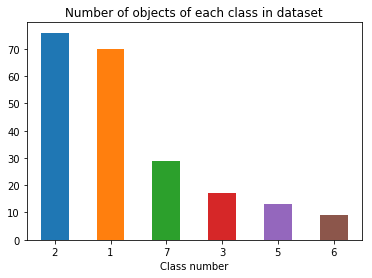

In [5]:
class_counts  = pd.value_counts(data['TYPE'].values)
class_counts.plot.bar()
plt.title("Number of objects of each class in dataset")
plt.xlabel("Class number")
plt.xticks(rotation=-1)
plt.show()

Looks like glass of type №2 more frequantly occurs in dataset

Let's normalize our data. We're using MixMaxNormalizer() which works like this:

\begin{equation*}
x' = (x - MIN[X])/(MAX[X] - MIX[X])
\end{equation*}

In [7]:
def min_max_normalizer(X):
    scaler = MinMaxScaler()
    new_X = scaler.fit_transform(X)
    return new_X

X_Scaled = min_max_normalizer(X)

Comparing accuracies of classification algorrithms K-Nearest Neighbor and Decision Tree on scaled and inscaled data (also looking for optimal number of k-neighbors):

In [8]:
def run_kneighbors(X, Y):
    cv_scores = []
    for k in range (1,20):
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, Y,cv=6)
        cv_scores.append(scores.mean())
    return [1 - x for x in cv_scores]

def run_decision_tree(X,Y):
    decTree = DecisionTreeClassifier()
    c_v_s = cross_val_score(decTree, X, Y, cv=6)
    return 1 - c_v_s.mean()


error_not_scaled = run_kneighbors(X, y)
min_error = min(error_not_scaled) * 100
optimal_kn = error_not_scaled.index(min(error_not_scaled)) + 1
print ("Not scaled data: KNeighbors reached %.1f%% error with %d number of neighbors" % (min_error,
                                                                                         optimal_kn))

error_scaled = run_kneighbors(X_Scaled, y)
min_error = min(error_scaled) * 100
optimal_kn = error_scaled.index(min(error_scaled)) + 1
print ("Scaled data: KNeighbors reached %.1f%% error with %d number of neighbors\n" % (min_error, optimal_kn))

print ("Not scaled data: Decision tree reached %.1f%% error" % (run_decision_tree(X,y) * 100))
print ("Scaled data: Decision tree reached %.1f%% error" % (run_decision_tree(X_Scaled,y) * 100))

Not scaled data: KNeighbors reached 35.5% error with 1 number of neighbors
Scaled data: KNeighbors reached 35.0% error with 3 number of neighbors

Not scaled data: Decision tree reached 38.5% error
Scaled data: Decision tree reached 43.0% error


It looks like KNN is more accurate than a Decision Tree. Scaling of data doesn't significant improvement for KNN and makes Decision Tree even worse.

Next graph shows dependecy of error on number of neighbors for KNN.

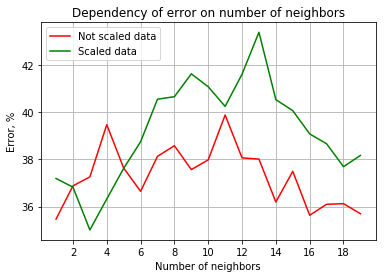

In [10]:
neighbors = range(1,20)
plt.title("Dependency of error on number of neighbors")
plt.plot(neighbors, [e * 100 for e in error_not_scaled],  color='r', label='Not scaled data')
plt.plot(neighbors, [e * 100 for e in error_scaled],  color='g', label='Scaled data')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.legend()
plt.ylabel("Error, %")
plt.xlabel("Number of neighbors")
plt.show()


Minimum error (35%) is achived on scaled data with K=3.

# HW3 (dicrease dimension)

Let's try to reduce dimensionality of our data using PCA and look how error decreases when we take out components:

In [15]:
number_of_components = range(1,9)
errors_knn = []
errors_tree = []
for i in number_of_components:
    pca = PCA(n_components=i).fit(X_Scaled)
    X_t = pca.transform(X)
    X_t_Scaled = min_max_normalizer(X_t)

    knn = KNeighborsClassifier()
    knn_accuracy = cross_val_score(knn, X_t_Scaled, y, cv=6)
    errors_knn.append((1 - knn_accuracy.mean()) * 100)

    tree = DecisionTreeClassifier()
    tree_accuracy = cross_val_score(tree, X_t_Scaled, y, cv=6)
    errors_tree.append((1 - tree_accuracy.mean()) * 100)

First we reduce dimension than we scale data using MinMaxNormalizer()

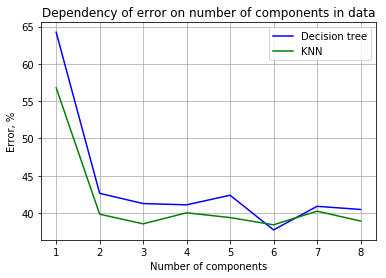

In [13]:
plt.title("Dependency of error on number of components in data")
plt.plot(number_of_components, errors_tree,  color='b', label='Decision tree')
plt.plot(number_of_components, errors_knn,  color='g', label='KNN')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.legend()
plt.ylabel("Error, %")
plt.xlabel("Number of components")
plt.show()

As we can see greater number of components the lower the error for both methods

## HW 4 (Learning Curve)

Let's noise our data. First of all we need to normalize our using StandardScaler():

In [17]:
def standard_normalizer(X):
    scaler = StandardScaler()
    new_X = scaler.fit_transform(X)
    return new_X

This scaler works like this:
\begin{equation*}
 x' = (x - M[X])/{\sigma}[X]
 \end{equation*}
 
 where ${\sigma}$ - stanard deviation. In this case, most values fall within the range (-3${\sigma}$ ; 3${\sigma}$)
 
 Now we can make noise:

In [90]:
def get_noisy_x(X, mean, stddev):

    rows = X.shape[0]
    cols = X.shape[1]

    noise = np.random.normal(mean, stddev/100,(rows, cols))

    noisy_X = X + noise
    return noisy_X

X_Normal_Scaled = standard_normalizer(X)
noisy_X = get_noisy_x(X_Normal_Scaled, 0, 10)

print("No noise:")
print (X_Normal_Scaled [:5])
print("\nNoise:")
print (noisy_X[:5])


No noise:
[[ 0.87286765  0.28495326  1.25463857 -0.69244192 -1.12708201 -0.67170546
  -0.14576634 -0.35287683 -0.5864509 ]
 [-0.24933347  0.59181718  0.63616803 -0.17046023  0.10231907 -0.02621325
  -0.79373376 -0.35287683 -0.5864509 ]
 [-0.72131806  0.14993314  0.60142249  0.19091171  0.43878673 -0.16453301
  -0.82894938 -0.35287683 -0.5864509 ]
 [-0.23283051 -0.24285268  0.69870999 -0.31099376 -0.0529737   0.11210651
  -0.51905192 -0.35287683 -0.5864509 ]
 [-0.31204471 -0.16920534  0.65006624 -0.41137486  0.55525631  0.08136879
  -0.62469878 -0.35287683 -0.5864509 ]]

Noise:
[[ 0.97669925  0.25046033  1.28729888 -0.57084309 -1.19941941 -0.77444816
  -0.17457516 -0.21317563 -0.58558091]
 [-0.20224784  0.55934573  0.63786355 -0.14050108  0.25924902 -0.10029569
  -0.82184044 -0.3500916  -0.67340725]
 [-0.6875697   0.21500975  0.53846702  0.38858935  0.44170947 -0.28202336
  -0.77926173 -0.40688406 -0.63523995]
 [-0.16503775 -0.1056597   0.73790683 -0.44660134 -0.09947652  0.08153413
  -

Let't draw learning curve using <b>sklearn.model_selection.learning_curve:

In [82]:
def plot_learning_curve(estimator, title, X, y, Noises, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)

    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="no noise")

    i = 1
    for noise_x in Noises:
        label = "noise " + i.__str__()
        
        train_sizes, new_train_scores, new_test_scores = learning_curve(
            estimator, noise_x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        
        new_train_scores_mean = np.mean(new_train_scores, axis=1)
        plt.plot(train_sizes, new_train_scores_mean,
                label=label)
        i += 1

    plt.legend(loc="best")
    plt.show()

Noise our data with step and then draw curve for each data. We use cross validation with 100 iterations to get smoother mean test and train score curves, each time with 20% data randomly selected as a validation set.

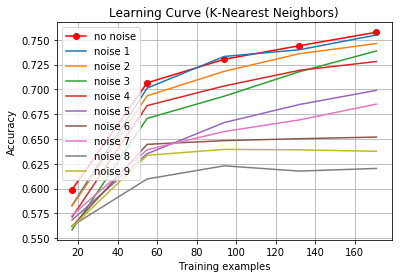

In [91]:
title = "Learning Curves (K-Nearest Neighbors)"
cv = ShuffleSplit(n_splits=100, test_size=0.2)
estimator = KNeighborsClassifier()

noisy_data = []
for i in range(1,10):
    X_Noisy = get_noisy_x(X_Normal_Scaled,mean=0, stddev=10*(i - 1))
    noisy_data.append(X_Noisy)

plot_learning_curve(estimator,"Learning Curve (K-Nearest Neighbors)", X, y, noisy_data,cv = cv)